# CNN with Keras on CIFAR10

Modify your MLP version from the previous exercise towards Convolutional Neural Networks.

## Loading the packages

In [1]:
# First, import TF and get its version.
import tensorflow as tf
tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print('WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('OK: TensorFlow >= 2.0.0' + '.\033[0m')

OK: TensorFlow >= 2.0.0.


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout
from tensorflow.keras import utils
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import confusion_matrix

%matplotlib inline

# fix random seed for reproducibility
np.random.seed(42)

# GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Loading the raw data

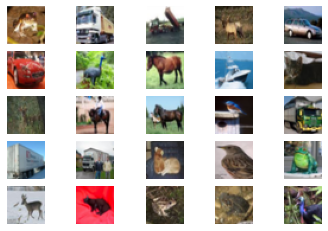

In [3]:
def show_imgs(X):
    plt.figure(1)
    k = 0
    for i in range(0,5):
        for j in range(0,5):
            plt.subplot2grid((5,5),(i,j))
            plt.imshow(X[k], cmap='gray')
            k = k+1
            plt.axis('off')
    # show the plot
    plt.show()
    
# Load data & split data between train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
CLASS_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

show_imgs(X_train)

In [4]:
# Normalize input
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

n_classes = 10
# Conversion to class vectors
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)

50000 train samples
10000 test samples


## Simple CNN

### Define the network

In [5]:
E = 30
B = 128
D = X_train.shape[1:]

def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), input_shape=D, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
    
    return model

tf.keras.backend.clear_session()
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


### Compile and train the network

In [6]:
log = model.fit(X_train, Y_train, batch_size=B, epochs=E,
                    verbose=1, validation_data=(X_test, Y_test))

Epoch 1/30
391/391 [==============================] - 4s 5ms/step - loss: 1.8096 - accuracy: 0.3582 - val_loss: 1.3972 - val_accuracy: 0.5156
Epoch 2/30
391/391 [==============================] - 1s 4ms/step - loss: 1.3516 - accuracy: 0.5327 - val_loss: 1.2831 - val_accuracy: 0.5503
Epoch 3/30
391/391 [==============================] - 2s 4ms/step - loss: 1.2227 - accuracy: 0.5767 - val_loss: 1.2513 - val_accuracy: 0.5649
Epoch 4/30
391/391 [==============================] - 2s 4ms/step - loss: 1.1588 - accuracy: 0.6011 - val_loss: 1.2110 - val_accuracy: 0.5767
Epoch 5/30
391/391 [==============================] - 2s 4ms/step - loss: 1.1079 - accuracy: 0.6204 - val_loss: 1.1355 - val_accuracy: 0.6047
Epoch 6/30
391/391 [==============================] - 2s 4ms/step - loss: 1.0621 - accuracy: 0.6317 - val_loss: 1.1455 - val_accuracy: 0.5967
Epoch 7/30
391/391 [==============================] - 2s 4ms/step - loss: 1.0248 - accuracy: 0.6459 - val_loss: 1.1334 - val_accuracy: 0.6056
Epoch 

### Evaluate the network

#### Loss evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

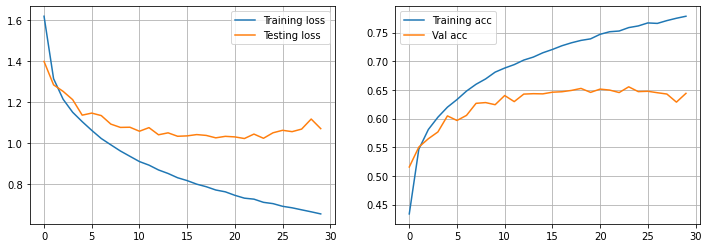

In [7]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Val acc')
ax2.legend()
ax2.grid()

#### Overall accuracy evaluation on test set
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [8]:
loss_train, metric_train = model.evaluate(X_train, Y_train, verbose=0)
loss_test, metric_test = model.evaluate(X_test, Y_test, verbose=0)
print('TRAIN: \t loss: {0:.4f}\t accuracy: {1:.4f}'.format(loss_train, metric_train))
print('TEST: \t loss: {0:.4f}\t accuracy: {1:.4f}'.format(loss_test, metric_test))

TRAIN: 	 loss: 0.6265	 accuracy: 0.7886
TEST: 	 loss: 1.0698	 accuracy: 0.6440


## Deeper CNN

In [9]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

project_id = 'deep-learning-sw08'

wandb: Currently logged in as: fabiangroeger (use `wandb login --relogin` to force relogin)


### Define the network

In [10]:
D = X_train.shape[1:]

# initialize wandb with your project name and optionally with configutations.
run = wandb.init(project=project_id,
           config={
              "learning_rate": 0.005,
              "epochs": 25,
              "batch_size": 64,
               "activation": 'relu',
              "loss_function": "categorical_crossentropy",
              "architecture": "CNN",
              "dataset": "CIFAR-10"
           })
config = wandb.config

def create_model(config):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), input_shape=D, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(loss=config.loss_function, 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate), 
                  metrics=['accuracy'])
    
    return model

tf.keras.backend.clear_session()
model = create_model(config)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


### Compile and train the network
In Keras, we call the methods `compile()` and `fit()`. For the compile phase, we need to specify the **loss** function which should be set in the case of multi-class classification to `categorical_crossentropy`. We also need to specify the optimizer strategy. In this case the `rmsprop` or `adam` can be used.

In [11]:
# in order to get prediction on small subset of images.
val_images, val_labels = X_test[:32], Y_test[:32]

log = model.fit(X_train, Y_train, 
                epochs=config.epochs, 
                batch_size=config.batch_size,
                validation_data=(X_test, Y_test),
                callbacks=[WandbCallback(data_type='image', 
                                   training_data=(val_images, val_labels), 
                                   labels=CLASS_NAMES)],
                verbose=0)

### Evaluate the network

#### Loss evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

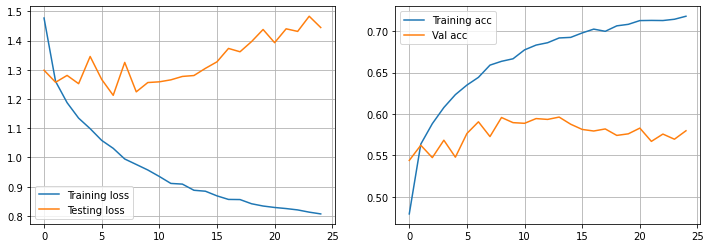

In [12]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Val acc')
ax2.legend()
ax2.grid()

#### Overall accuracy evaluation on test set
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [13]:
loss_train, metric_train = model.evaluate(X_train, Y_train, verbose=0)
loss_test, metric_test = model.evaluate(X_test, Y_test, verbose=0)
print('TRAIN: \t loss: {0:.4f}\t accuracy: {1:.4f}'.format(loss_train, metric_train))
print('TEST: \t loss: {0:.4f}\t accuracy: {1:.4f}'.format(loss_test, metric_test))

# log to wandb
wandb.log({'Train Error Rate': round((1-metric_train)*100, 2)})
wandb.log({'Test Error Rate': round((1-metric_test)*100, 2)})

TRAIN: 	 loss: 0.7053	 accuracy: 0.7558
TEST: 	 loss: 1.4443	 accuracy: 0.5797


## Hyperparameter optimization

In [14]:
def create_model(config):
    model = Sequential()
    
    ### 1. layer
    model.add(Conv2D(filters=config.filters[0], 
                     kernel_size=(config.kernel, config.kernel), 
                     strides=1, 
                     padding="same", 
                     activation=None,
                     kernel_initializer=config.initializer,
                     input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(Activation(config.activation))
    
    ### 2. layer
    model.add(Conv2D(filters=config.filters[0], 
                     kernel_size=(config.kernel, config.kernel), 
                     strides=1, 
                     padding="same", 
                     activation=None,
                     kernel_initializer=config.initializer))
    model.add(BatchNormalization())
    model.add(Activation(config.activation))
    
    ### 3.+ layers
    for layer in config.filters[1:]:        
        model.add(Conv2D(filters=layer, 
                         kernel_size=(config.kernel, config.kernel), 
                         strides=1, 
                         padding="same", 
                         activation=None,
                         kernel_initializer=config.initializer))
        model.add(BatchNormalization())
        model.add(Activation(config.activation))
        model.add(MaxPooling2D())
        model.add(Dropout(0.2))
    
    ### 2nd last layer
    model.add(Flatten())
    model.add(tf.keras.layers.Dense(1024, activation=None, kernel_initializer=config.initializer))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation(config.activation))
    model.add(tf.keras.layers.Dropout(0.2))
    
    ### last layer
    model.add(Dense(n_classes, activation='softmax'))
    
    return model

In [15]:
def train():
    # Specify the hyperparameter to be tuned along with
    # an initial value
    config_defaults = {
        'batch_size': 32,
        'learning_rate': 0.001,
        'filters': [32, 64, 128, 256, 512],
        'activation': 'relu',
        'initializer': 'glorot_uniform',
        'kernel': 3
    }
    
    # Initialize wandb with a sample project name
    wandb.init(project=project_id,
               config=config_defaults)

    # Specify the other hyperparameters to the configuration, if any
    wandb.config.epochs = 30
    wandb.config.loss_function = 'categorical_crossentropy'
    config = wandb.config
    
    # define model
    tf.keras.backend.clear_session()
    model = create_model(config)
    
    # compile model
    model.compile(loss=config.loss_function, 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate), 
                  metrics=['accuracy'])
    
    # train model
    _ = model.fit(X_train, Y_train, 
                epochs=config.epochs, 
                batch_size=config.batch_size,
                validation_data=(X_test, Y_test),
                callbacks=[WandbCallback()],
                verbose=0)
    
    # evaluate model
    loss_test, metric_test = model.evaluate(X_test, Y_test, verbose=0, callbacks=[WandbCallback()])
    wandb.log({'Test Error Rate': round((1-metric_test)*100, 2)})

In [16]:
sweep_config = {
  'method': 'bayes', 
  'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
  },
  'early_terminate':{
      'type': 'hyperband',
      'min_iter': 5
  },
  'parameters': {
      'batch_size': {
          'values': [32, 64, 128, 256]
      },
      'learning_rate': {
          'values': [0.005, 0.001, 0.0005, 0.0001]
      },
      'filters': {
          'values': [
              [32, 64, 128, 256, 512],
              [32, 64, 128, 256, 512, 512],
          ]
      },
      'activation': {
          'values': ['elu', 'selu', 'relu']
      },
      'initializer': {
          'values': ['he_normal', 'he_uniform', 'glorot_uniform', 'glorot_normal', 'lecun_normal']
      },
      'kernel': {
          'values': [3]
      }
  }
}

In [17]:
# was already performed, results below
if False:
    sweep_id = wandb.sweep(sweep_config, project=project_id)
    wandb.agent(sweep_id, function=train)

### Results

In [18]:
df_results = pd.read_csv('wandb_export_sweep.csv')
df_results.sort_values('val_accuracy', ascending=False)

,Name,activation,batch_size,filters,initializer,learning_rate,epochs,kernel,loss_function,Test Error Rate,accuracy,best_epoch,best_val_loss,epoch,loss,val_accuracy,val_loss
0,stilted-sweep-103,relu,32,"[32,64,128,256,512,512]",he_normal,0.0005,30,3,categorical_crossentropy,12.87,0.96408,12,0.458142,29,0.103270,0.8713,0.526539
1,mild-sweep-136,relu,32,"[32,64,128,256,512,512]",lecun_normal,0.0005,30,3,categorical_crossentropy,12.87,0.96380,17,0.470734,29,0.103414,0.8713,0.516457
2,fiery-sweep-102,relu,32,"[32,64,128,256,512,512]",lecun_normal,0.0005,30,3,categorical_crossentropy,12.93,0.96466,12,0.443955,29,0.099485,0.8707,0.491753
3,giddy-sweep-131,relu,32,"[32,64,128,256,512,512]",lecun_normal,0.0005,30,3,categorical_crossentropy,12.94,0.96340,16,0.451641,29,0.104550,0.8706,0.504028
4,tough-sweep-98,relu,32,"[32,64,128,256,512,512]",he_normal,0.0005,30,3,categorical_crossentropy,12.97,0.96388,15,0.474030,29,0.104190,0.8703,0.516633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,frosty-sweep-73,selu,128,"[32,64,128,256,512,512]",lecun_normal,0.0001,30,3,categorical_crossentropy,NaN,0.68396,7,1.003437,7,0.890850,0.6552,1.003437
149,fallen-sweep-15,relu,128,"[32,64,128,256,512]",he_normal,0.0001,30,3,categorical_crossentropy,NaN,0.70606,9,1.038807,9,0.829490,0.6395,1.038807
150,earthy-sweep-27,elu,256,"[32,64,128,256,512,512]",lecun_normal,0.0001,30,3,categorical_crossentropy,NaN,0.63862,6,1.204057,6,1.012315,0.5869,1.204057
151,snowy-sweep-137,relu,64,"[32,64,128,256,512,512]",he_normal,0.0001,30,3,categorical_crossentropy,NaN,0.72792,8,1.140580,10,0.765311,0.5787,1.235022


### Train Best Model

In [19]:
config = wandb.config
config.activation = 'relu'
config.batch_size = 32
config.filters = [32,64,128,256,512,512]
config.initializer = 'he_normal'
config.learning_rate = 0.0005
config.kernel = 3
config.loss_function = 'categorical_crossentropy'
config.epochs = 30

tf.keras.backend.clear_session()
best_model = create_model(config)

# compile model
best_model.compile(loss=config.loss_function, 
                optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate), 
                metrics=['accuracy'])

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  patience=5,
                                                  restore_best_weights=True)

# train model
log = best_model.fit(X_train, Y_train, 
                    epochs=config.epochs, 
                    batch_size=config.batch_size,
                    validation_data=(X_test, Y_test),
                    callbacks=[early_stopping],
                    verbose=0)

# evaluate model
loss_train, metric_train = best_model.evaluate(X_train, Y_train, verbose=0)
loss_test, metric_test = best_model.evaluate(X_test, Y_test, verbose=0)
print('TRAIN: \t loss: {0:.4f}\t accuracy: {1:.4f}'.format(loss_train, metric_train))
print('TEST: \t loss: {0:.4f}\t accuracy: {1:.4f}'.format(loss_test, metric_test))

TRAIN: 	 loss: 0.0248	 accuracy: 0.9936
TEST: 	 loss: 0.5084	 accuracy: 0.8664


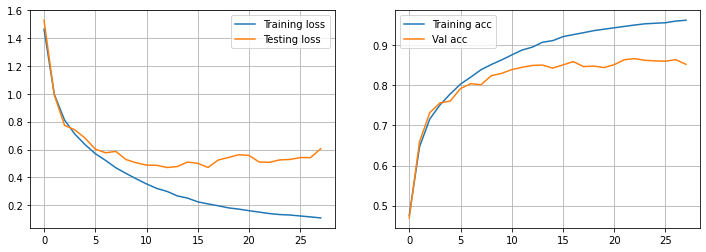

In [20]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Val acc')
ax2.legend()
ax2.grid()

**Best Model**   
TRAIN:
- loss: 0.0248
- accuracy: 0.9936  

TEST:
- loss: 0.5084
- accuracy: 0.8664